# 전이 학습으로 모델 성능 극대화 
- 대규모 데이터 셋에서 학습된 기존의 네트워크를 불러
- CNN 모델의 앞쪽을 이 네트워크로 채웁니다. 
- 그리고 뒤쪽 레이어에서 나의 프로젝트와 연결
- 그리고 이 두 네트워크가 잘 맞물리게끔 미세 조정(Fine tuning)

# 미리 학습된 모델인 VGGNet
- 옥스포드대학의 연구팀 VGG
- 2014년 이미지넷 이미지 인식 대회에서 2위
- VGG16

In [ ]:
# https://thebook.io/080228/part06/01/

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
                                   width_shift_range=0.1, height_shift_range=0.1, 
                                   fill_mode='nearest')

In [5]:
train_generator = train_datagen.flow_from_directory('train', target_size=(150, 150), 
                                                    batch_size=5, class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
                                  width_shift_range=0.1, height_shift_range=0.1, 
                                  fill_mode='nearest')

Found 160 images belonging to 2 classes.


In [6]:
test_generator = test_datagen.flow_from_directory('test', target_size=(150, 150), 
                                                  batch_size=5, class_mode='binary')



Found 120 images belonging to 2 classes.


In [7]:
transfer_model = VGG16(weights='imagenet', include_top=False, 
                       input_shape=(150, 150, 3))
# include_top은 전체 VGG16의 마지막 층, 즉 분류를 담당하는 곳을 불러올지 말지
# 로컬 네트워크를 연결할 것이므로 False로 설정
transfer_model.trainable = False
# 불러올 부분은 새롭게 학습되는 것이 아니므로 
# 학습이 되지 않도록 transfer_model.trainable 옵션 역시 False

58892288/58889256 [==============================] - 16s 0us/step


In [8]:
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))

In [11]:
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
finetune_model.compile(loss='sparse_categorical_crossentropy', 
                       optimizer=optimizers.Adam(learning_rate=0.0002), 
                       metrics=['accuracy'])

In [ ]:
steps_train = len(train_generator)
steps_test = len(test_generator)

In [15]:
history = finetune_model.fit(
       train_generator,
       steps_per_epoch=steps_train,
       epochs=20,
       validation_data=test_generator,
       validation_steps=steps_test)

Train for 32 steps, validate for 24 steps
Epoch 1/20
32/32 [==============================] - 11s 359ms/step - loss: 0.4997 - accuracy: 0.7812 - val_loss: 0.4423 - val_accuracy: 0.8583
Epoch 2/20
32/32 [==============================] - 11s 345ms/step - loss: 0.4089 - accuracy: 0.8250 - val_loss: 0.3275 - val_accuracy: 0.9000
Epoch 3/20
32/32 [==============================] - 11s 347ms/step - loss: 0.3231 - accuracy: 0.8625 - val_loss: 0.3071 - val_accuracy: 0.9000
Epoch 4/20
32/32 [==============================] - 11s 341ms/step - loss: 0.2198 - accuracy: 0.9312 - val_loss: 0.2352 - val_accuracy: 0.9500
Epoch 5/20
32/32 [==============================] - 11s 345ms/step - loss: 0.2024 - accuracy: 0.9563 - val_loss: 0.2238 - val_accuracy: 0.9167
Epoch 6/20
32/32 [==============================] - 12s 367ms/step - loss: 0.1691 - accuracy: 0.9688 - val_loss: 0.1971 - val_accuracy: 0.9333
Epoch 7/20
32/32 [==============================] - 11s 358ms/step - loss: 0.1561 - accuracy: 0.9375

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

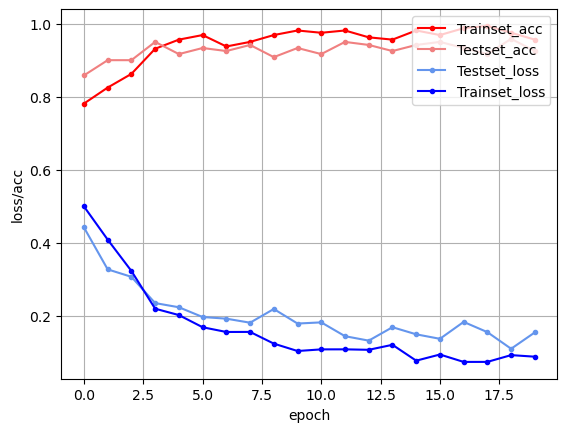

In [19]:
# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c='cornflowerblue', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

In [ ]:
# 훨씬 더 안정적으로 나왔음